Tema: **Klasterizacija korisničkih recenzija hrane primenom NLP (Natural Language Processing)**

Predmet rada: Recenzije korisnika o prehrambenim proizvodima, gde je cilj prepoznati skrivene obrasce i teme koje kupci najčešće pominju

Svrha rada: Automatizacija procesa analize povratnih informacija korisnika tako da se omogućava kompanijama da trenutno identifikuju ključne kategorije

Dataset: [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download) (preuzet sa platforme Kaggle)

Sadržaj dataset-a: Recenzije hrane koje uključuju sledeće atribute: ProductId, UserId, ProfileName, HelpfulnessNumerator,..., Text. Fokus je na atributu Text koji predstavlja recenziju korisnika u nekoliko rečenica

Metodologija: Korišćen je pristup nenadgledanog učenja (Unsupervised Learning) fokusiran na ekstrakciju semantičkog značenja iz nestrukturiranih recenzija

**Embedding model**: Izabran je Sentence-BERT (SBERT) model, konkretno all-MiniLM-L6-v2 jer pretvara rečenice u numeričke vektore od 384 dimenzije koji čuvaju duboki kontekst i semantičko značenje reči.

**Izbor algoritma klasterizacije i broja klastera**: Korišćen je K-Means algoritam zbog njegove efikasnosti u grupisanju sličnih tekstualnih reprezentacija. Korišćen je hiper parametar fiksiran random_state= 42 radi ponovljivosti rezultata. Primenom Elbow i Silhouette Score metode utvrđen je optimalan broj klastera, s obzirom na to da Elbow kriva nakon te tačke počinje linearno da opada, dok Silhouette metoda u toj tački dostiže nivo stabilnosti.

**Interpretacija klastera**: Tumačenje je izvršeno pomoću KeyBERT modela sa MMR (Maximal Marginal Relevance) algoritmom kako bi se osigurala raznovrsnost ključnih reči, koji je iz svakog klastera izvukao najrelevantnije n-grame (fraze od jedne ili dve reči) i prema tome su dobijeni konkretni tipovi recenzija (navedeni na dnu noteboook-a).

**Učitavanje i prikaz dataset-a**

In [3]:
import pandas as pd
from google.colab import files


df = pd.read_csv("Reviews.csv", nrows=  5000)

df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [ ]:
df.shape

(5000, 10)

**Sredjivanje podataka u dataset-u**

In [4]:
df = df[['Text']].copy()


print('Broj redova pre sredjivanja: ', len(df))

#provera null i nan vrednosti
print('Broj null vrednosti: ', df.isnull().sum())
print('Broj na vrednosti: ', df.isna().sum())

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

#izbacivanje recenzija koje sadrze manje od 10 reci
df = df[df['Text'].apply(lambda x: len(str(x).split()) > 10)]


df = df.reset_index(drop=True)

print('Broj redova nakon sredjivanja: ', len(df))


Broj redova pre sredjivanja:  5000
Broj null vrednosti:  Text    0
dtype: int64
Broj na vrednosti:  Text    0
dtype: int64
Broj redova nakon sredjivanja:  4984


In [ ]:
!pip install -U sentence-transformers

**Transformacija tekstualne recenzije u numeričke vektore (embeddings) od 384 dimenzije pomoću SBERT modela**

In [5]:
from sentence_transformers import SentenceTransformer

#ovo je naziv već obučenog modela koji predstavlja "prevodioca" teksta u brojeve da bi računar razumeo
model = SentenceTransformer('all-MiniLM-L6-v2')

# "prevod" texta u brojeve
embeddings = model.encode(df['Text'].tolist())

embeddings.shape

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(4984, 384)

**Odredjivanje broja klastera putem Elbow i Silhouette Score metode**

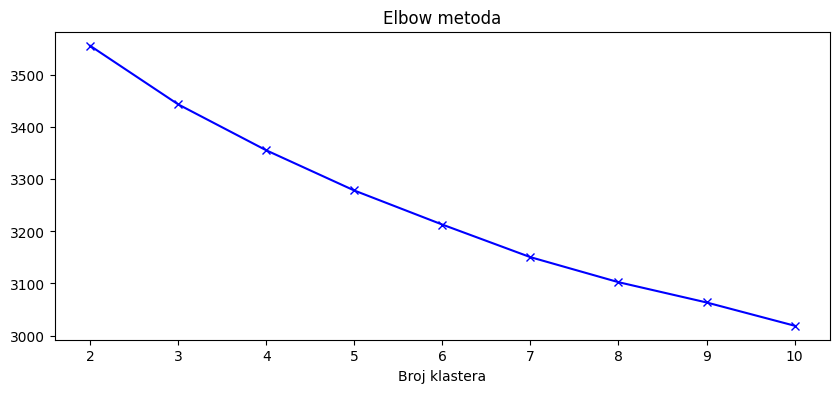

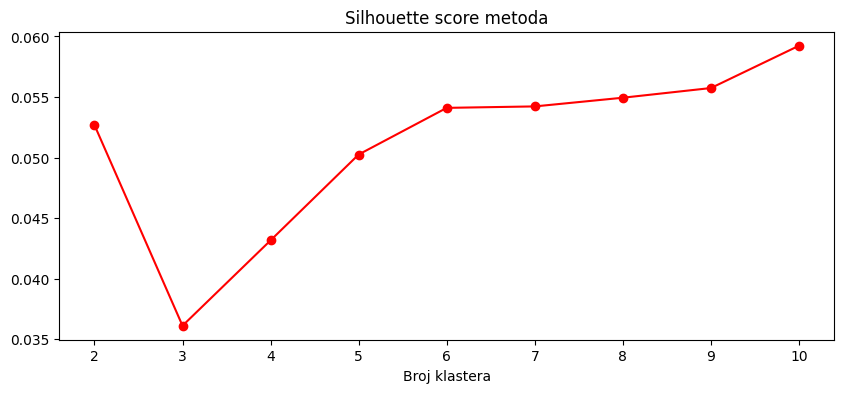

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette_vals = []


for k in range(2, 11):
  kmeans = KMeans(n_clusters= k, random_state= 42, n_init= 10)
  cluster_labels = kmeans.fit_predict(embeddings)

  #za elbow metodu
  inertia.append(kmeans.inertia_)
  #za silhouette score
  score = silhouette_score(embeddings, cluster_labels)
  silhouette_vals.append(score)



plt.figure(figsize= (10, 4))
plt.plot(range(2, 11), inertia, 'bx-')
plt.xlabel('Broj klastera')
plt.title('Elbow metoda')
plt.show()



plt.figure(figsize= (10, 4))
plt.plot(range(2, 11), silhouette_vals, 'ro-')
plt.xlabel('Broj klastera')
plt.title('Silhouette score metoda')
plt.show()

**Finalna klasterizacija KMeans modela i dodela labela**



In [7]:
final_kmeans= KMeans(n_clusters= 6, random_state= 42, n_init= 10)
df['Cluster'] = final_kmeans.fit_predict(embeddings)

print('Broj recenzija u svakom klasteru: ', df['Cluster'].value_counts())


Broj recenzija u svakom klasteru:  Cluster
2    1280
3    1166
5     937
4     748
1     450
0     403
Name: count, dtype: int64


**Provera podataka na svakom od klastera**

In [8]:
for i in range(6):
  print('Klaster broj ', i)
  podaci = df[df['Cluster'] == i]['Text'].head(2).values
  for p in podaci:
    print(f'-> {p[:100]}...')


Klaster broj  0
-> I have bought several of the Vitality canned dog food products and have found them all to be of good...
-> This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats ...
Klaster broj  1
-> For those of us with celiac disease this product is a lifesaver and what could be better than gettin...
-> We made chocolate chip cookies with BRM Garbanzo Bean Flour and the results were fantastic!  The bro...
Klaster broj  2
-> This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin wi...
-> If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in...
Klaster broj  3
-> I got this for my Mum who is not diabetic but needs to watch her sugar intake, and my father who sim...
-> I have never been a huge coffee fan. However, my mother purchased this little machine and talked me ...
Klaster broj  4
-> I love eating them and they are good for watching TV and look

**Vizuelizacija klastera u 2D prostoru pomoću t-SNE metode**



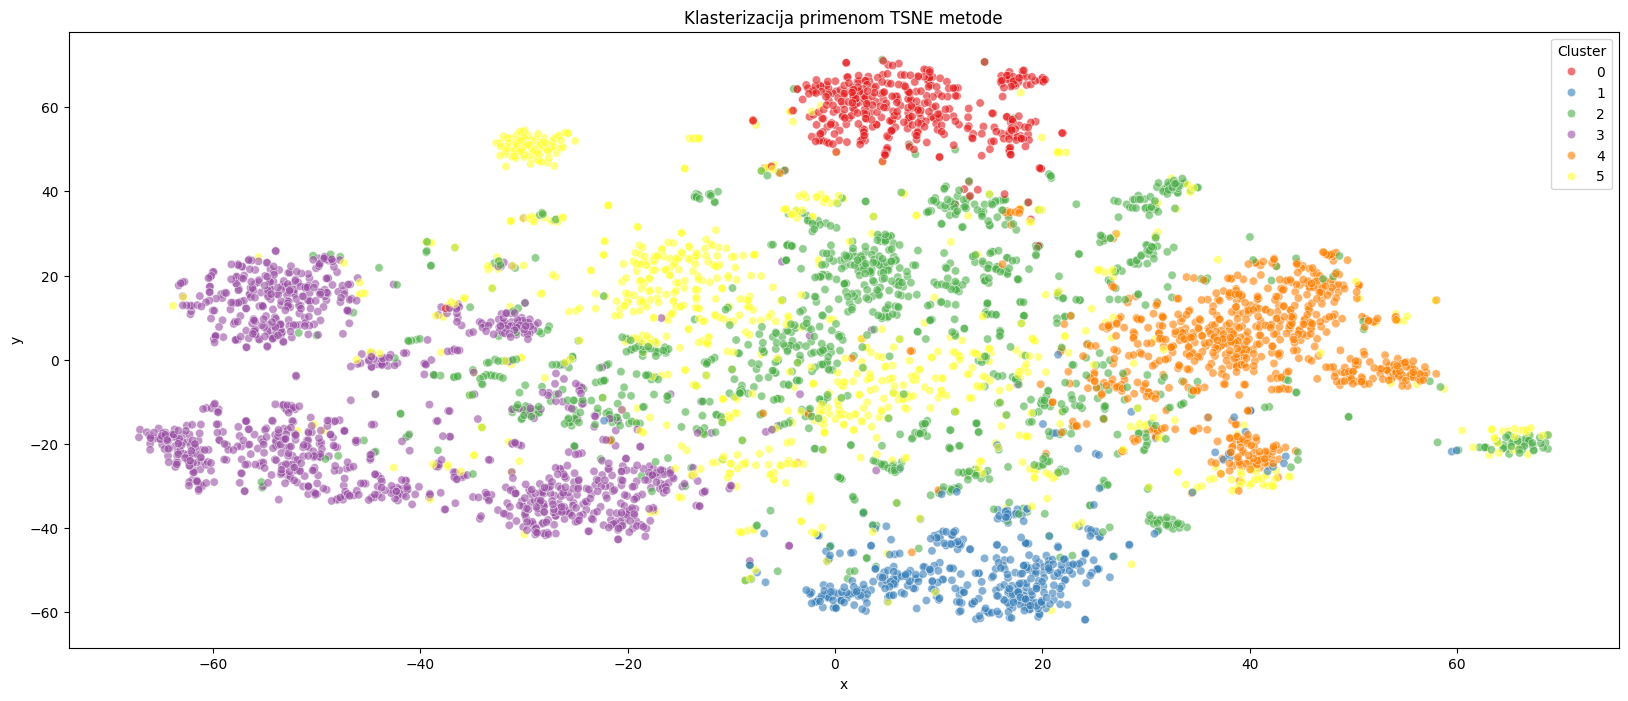

In [9]:
from sklearn.manifold import TSNE
import seaborn as sb
#tsne prevodi podatke iz 384d u 2d

tsne = TSNE(n_components= 2, random_state= 42, perplexity= 30)
embeddings_2d = tsne.fit_transform(embeddings)

df_vis = pd.DataFrame(embeddings_2d, columns= ['x', 'y'])
df_vis['Cluster'] = df['Cluster']

plt.figure(figsize= (20, 8))
sb.scatterplot(data= df_vis, x= 'x', y= 'y', hue= 'Cluster', palette= 'Set1', alpha= 0.6)

plt.title('Klasterizacija primenom TSNE metode')
plt.show()


In [10]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00


**Identifikacija tema putem KeyBERT modela**

Korišćen je KeyBERT model koji automatski dodeljuje "etikete" (tj. grupise po odredjenim rečima/frazama svaki klaster) svakom od 6 dobijenih klastera koji su izvučeni u prethodnim koracima putem KMeans algoritma klasterizacije

Sve teme po klasterima:



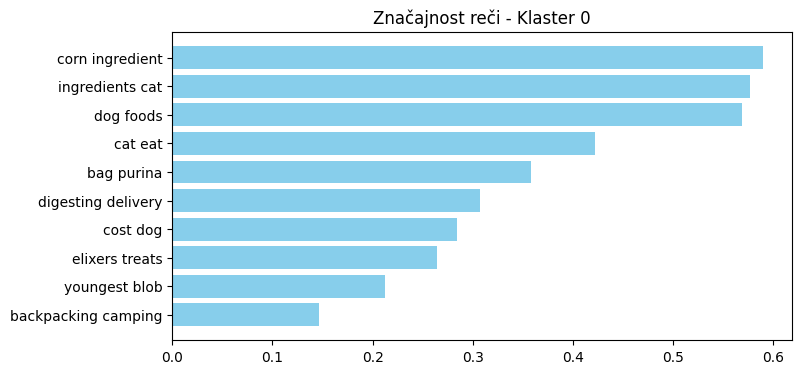

Za klaster broj 0
Kljucnereci: [('corn ingredient', 0.5894), ('ingredients cat', 0.5768), ('dog foods', 0.5692), ('cat eat', 0.4219), ('bag purina', 0.3581), ('digesting delivery', 0.3077), ('cost dog', 0.2838), ('elixers treats', 0.2647), ('youngest blob', 0.2125), ('backpacking camping', 0.1464)]


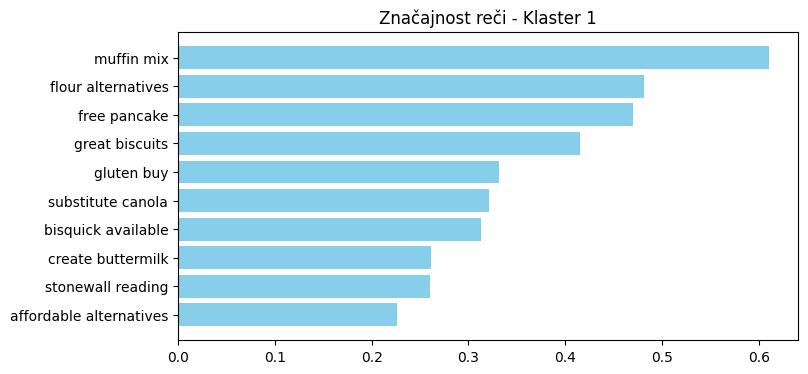

Za klaster broj 1
Kljucnereci: [('muffin mix', 0.6101), ('flour alternatives', 0.4813), ('free pancake', 0.4697), ('great biscuits', 0.4152), ('gluten buy', 0.3316), ('substitute canola', 0.3214), ('bisquick available', 0.3125), ('create buttermilk', 0.2608), ('stonewall reading', 0.2601), ('affordable alternatives', 0.2261)]


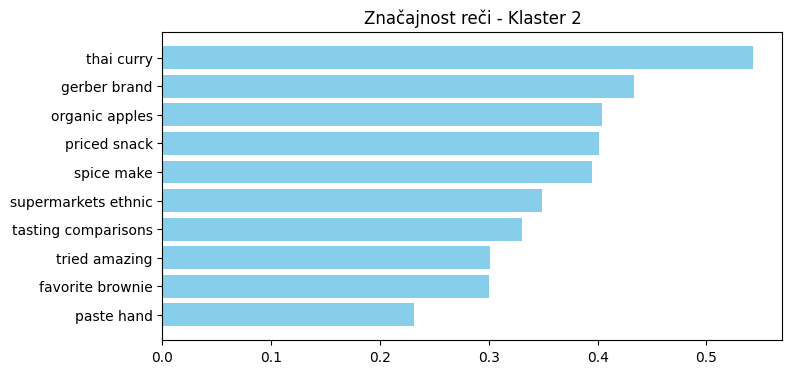

Za klaster broj 2
Kljucnereci: [('thai curry', 0.5428), ('gerber brand', 0.4337), ('organic apples', 0.4039), ('priced snack', 0.4016), ('spice make', 0.3948), ('supermarkets ethnic', 0.3485), ('tasting comparisons', 0.3305), ('tried amazing', 0.3013), ('favorite brownie', 0.3006), ('paste hand', 0.2308)]


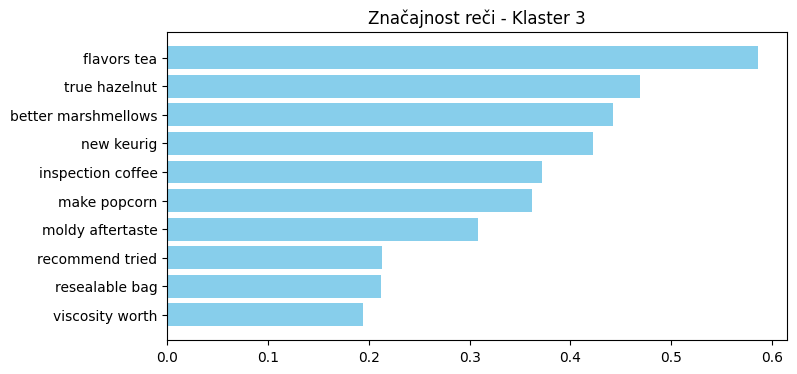

Za klaster broj 3
Kljucnereci: [('flavors tea', 0.5858), ('true hazelnut', 0.4689), ('better marshmellows', 0.4426), ('new keurig', 0.4226), ('inspection coffee', 0.3721), ('make popcorn', 0.3617), ('moldy aftertaste', 0.3083), ('recommend tried', 0.213), ('resealable bag', 0.212), ('viscosity worth', 0.1944)]


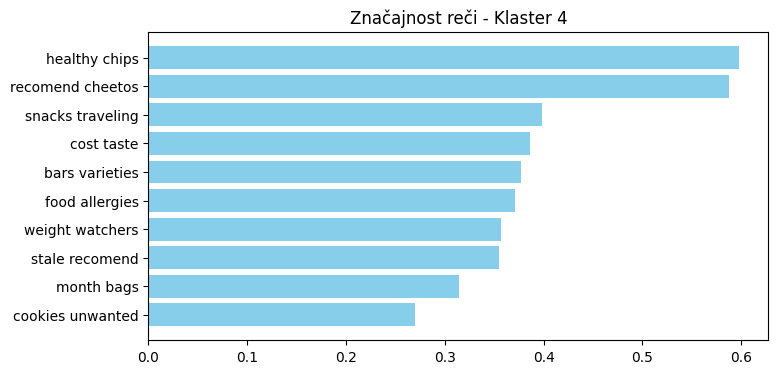

Za klaster broj 4
Kljucnereci: [('healthy chips', 0.5975), ('recomend cheetos', 0.5878), ('snacks traveling', 0.3983), ('cost taste', 0.3859), ('bars varieties', 0.3766), ('food allergies', 0.3706), ('weight watchers', 0.3565), ('stale recomend', 0.3548), ('month bags', 0.3139), ('cookies unwanted', 0.2698)]


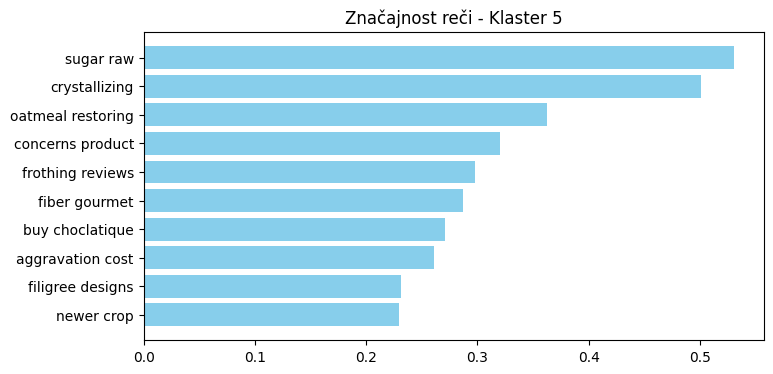

Za klaster broj 5
Kljucnereci: [('sugar raw', 0.5308), ('crystallizing', 0.5007), ('oatmeal restoring', 0.3622), ('concerns product', 0.3202), ('frothing reviews', 0.2981), ('fiber gourmet', 0.2875), ('buy choclatique', 0.2713), ('aggravation cost', 0.261), ('filigree designs', 0.2314), ('newer crop', 0.2296)]


In [12]:
from keybert import KeyBERT

k_model = KeyBERT(model= 'all-MiniLM-L6-v2')

print("Sve teme po klasterima:\n")

for i in range(6):
  #uzimanje 100 nasumicnih recenzija
  cluster_data = df[df['Cluster'] == i]['Text'].astype(str)
  tekst = " ".join(cluster_data.sample(n= min(100, len(cluster_data)), random_state= 42). tolist())

  keywords = k_model.extract_keywords(tekst, keyphrase_ngram_range= (1, 2), stop_words= 'english', top_n= 10, use_mmr= True)
  #stop_words= 'english' - ovime se ignorišu reči u engleskom jeziku poput the, a, an, to...

  words, vals = zip(*keywords)
  plt.figure(figsize=(8, 4))
  plt.barh(words[::-1], vals[::-1], color='skyblue')
  plt.title(f"Značajnost reči - Klaster {i}")
  plt.show()

  print(f'Za klaster broj {i}')
  print(f'Kljucnereci: {keywords}')


0 - hrana za ljubimce

1 - bezglutenska ishrana, pecenje (kolaca)

2 - egzoticna ishrana, organski prozivodi

3 - cajevi, kafa, kapsule za kafu

4 - zdravi slatkisi i zdrava hrana

5 - sirovine, zasladjivaci



Prosecne ocene po klasterima:
Cluster
0    4.277916
1    4.211111
2    4.134375
3    4.162093
4    4.219251
5    4.018143
Name: Score, dtype: float64


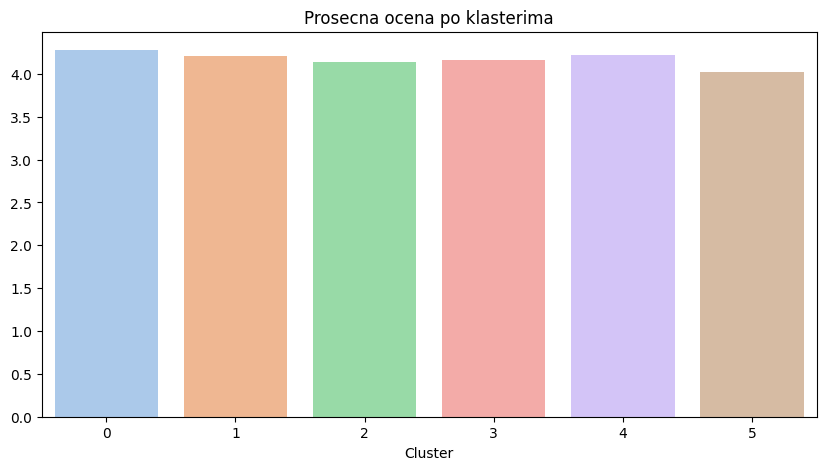

In [18]:
import seaborn as sb

df_original = pd.read_csv("Reviews.csv", nrows= 5000)
df['Score'] = df_original.loc[df.index, 'Score']

#prosecna ocena za svaki klaster
avg_cluster_score = df.groupby('Cluster')['Score'].mean()

plt.figure(figsize=(10, 5))
sb.barplot(x= avg_cluster_score.index, y= avg_cluster_score.values, palette= 'pastel')

plt.title('Prosecna ocena po klasterima')

print("Prosecne ocene po klasterima:")
print(avg_cluster_score)

Analizom prosečnih ocena po klasterima, utvrdjeno je da su kupci najviše zadovoljni hranom za ljubimce (Klaster 0), dok se pad zadovoljstva beleži kod osnovnih sirovina (Klaster 5). Srednje zadovoljni su kupci proizvoda bez glutena i zdravih grickalica (Klasteri 1 i 4), a odmah nakon njih kupci egzoticne, modernije hrane i konzumenti raznih vrsta kafa i cajeva.

**Ograničenja**: Glavno ograničenje je korišćenje K-Means metode koja svaku recenziju svrstava u samo jednu temu, iako kupci često pišu o više aspekata istovremeno (npr. i ukus i cena). Još jedno ograničenje je vezano za sam dataset, uzet je uzorak od 5000 recenzija. Takođe, interpretacija putem KeyBERT-a je vršena na nasumično izabranom uzorku od 100 recenzija po klasteru.

**Interpretacija**: Identifikovane specifične tržišne niše: od ishrane za ljubimce (Klaster 0) i specijalizovanih zamena za brašno i bezglutensku ishranu (Klaster 1), do premium sastojaka poput organskog voća i začina (Klaster 2). Klasteri 3 i 5 pokrivaju svet napitaka (kafa i čaj) i sirovina poput šećera, dok je Klaster 4 jasno izdvojio segment zdravih grickalica i dijetalnih proizvoda.

Povezivanjem sa ocenama (Score), primećeno je da su kupci najzadovoljniji u sektoru hrane za ljubimce, dok sirovine u rinfuzu beleže nešto niži prosek ocena.

**Zaključak**

Uspešnom realizacijom ovog rada demonstrirana je moć naprednih NLP tehnika u rešavanju problema nestrukturiranih podataka.

Ovakav pristup omogućava biznis sistemima da iz ogromne količine podataka (hiljada recenzija) izvuku konkretne i korisne informacije. Na primer, kompanija može brzo uočiti želje korisnika, odnosno šta misle o odredjenoj teksturi/saastojku (uočeno u Klasteru 2) ili identifikovati rastuće interesovanje za specifične dijetetske proizvode, što predstavlja značajnu prednost u odnosu na manuelnu analizu podataka.